In [71]:
import easyocr
from pdf2image import convert_from_path
import cv2
import numpy as np
import os
import re
from collections import defaultdict
from IPython.display import display, Image

# Initialize OCR model ONCE
reader = easyocr.Reader(['en'], gpu=True)

# Cache to avoid reprocessing images
ocr_cache = {}


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [74]:
def pdf_to_image(pdf_path, output_folder="output_images"):
    os.makedirs(output_folder, exist_ok=True)
    images = convert_from_path(pdf_path, dpi=300)
    image_paths = []
    for i, img in enumerate(images):
        path = os.path.join(output_folder, f"page_{i+1}.png")
        img.save(path, 'PNG')
        image_paths.append(path)
    return image_paths

def perform_ocr(image_path):
    

    image = cv2.imread(image_path)
    results = reader.readtext(image, text_threshold=0, width_ths=1.0)
    ocr_cache[image_path] = results
    print(f"✅ OCR done for: {image_path}")
    return results

def rank_by_font_size(ocr_results, tolerance=10):
    blocks = []
    for bbox, text, _ in ocr_results:
        y_top = bbox[0][1]
        y_bottom = bbox[2][1]
        height = abs(y_bottom - y_top)
        blocks.append({
            "text": text,
            "bbox": [[int(x), int(y)] for x, y in bbox],
            "height": height
        })

    if not blocks:
        return []
    
    block_w_highestheight = {
        "height" : 0
    }
    for block in blocks:
        if block["height"] > block_w_highestheight["height"]:
            block_w_highestheight = block

    max_height = block_w_highestheight["height"]
    if "," in block_w_highestheight["text"]:
        tolerance = block_w_highestheight["height"] - 50
    print(block_w_highestheight)
    print(tolerance)
    top_blocks = [
        block for block in blocks
        if abs(block["height"] - max_height) <= tolerance
    ]

    return top_blocks

def annotate_image(image_path, annotations, output_path="annotated.png"):
    image = cv2.imread(image_path)

    if not annotations:
        print("⚠️ No annotations to draw.")
        return

    all_points = [pt for ann in annotations for pt in ann["bbox"]]
    all_points_np = np.array(all_points)
    x, y, w, h = cv2.boundingRect(all_points_np)

    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.putText(image, "Headline", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imwrite(output_path, image)
    print(f"🖼 Annotated image saved: {output_path}")
    display(Image(filename=output_path))

def detect_embedded_images_by_structure(image_path, output_path="annotated_photos.png", min_area=5000):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (1, 1), 0)
    edges = cv2.Canny(blurred, 30, 100)

    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    candidate_boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect_ratio = w / float(h)

        if area > min_area and 0.5 < aspect_ratio < 2.0:
            candidate_boxes.append((x, y, w, h))

    # Remove nested boxes
    final_boxes = []
    for i, (x1, y1, w1, h1) in enumerate(candidate_boxes):
        cx1 = x1 + w1 // 2
        cy1 = y1 + h1 // 2
        is_nested = False
        for j, (x2, y2, w2, h2) in enumerate(candidate_boxes):
            if i != j:
                if x2 <= cx1 <= x2 + w2 and y2 <= cy1 <= y2 + h2:
                    if w2 * h2 > w1 * h1:  # Only count if the containing box is bigger
                        is_nested = True
                        break
        if not is_nested:
            final_boxes.append((x1, y1, w1, h1))

    # Draw results
    image_copy = image.copy()
    for x, y, w, h in final_boxes:
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image_copy, "Image", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Save and show debug images
    # cv2.imwrite("blurred_gray.png", blurred)
    # cv2.imwrite("canny_edges.png", edges)
    cv2.imwrite(output_path, image_copy)

    # print("📸 Visualizations saved:")
    # print("- Blurred grayscale: blurred_gray.png")
    # print("- Canny edges: canny_edges.png")
    print(f"- Final annotated: {output_path}")

    # display(Image(filename="blurred_gray.png"))
    # display(Image(filename="canny_edges.png"))
    display(Image(filename=output_path))

    return final_boxes


def annotate_headline_and_images(image_path, headline_blocks, image_boxes, output_path="final_annotated.png"):
    image = cv2.imread(image_path)

    # Draw headline box (green)
    if headline_blocks:
        all_points = [pt for ann in headline_blocks for pt in ann["bbox"]]
        all_points_np = np.array(all_points)
        x, y, w, h = cv2.boundingRect(all_points_np)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(image, "Headline", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Draw embedded image boxes (blue)
    for x, y, w, h in image_boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, "Image", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    cv2.imwrite(output_path, image)
    print(f"🖼 Combined annotation saved: {output_path}")
    display(Image(filename=output_path))





✅ OCR done for: ./img/Screenshot_21-7-2025_114433_mb.com.ph.jpeg
{'text': 'Walang', 'bbox': [[48, 252], [208, 272], [198, 325], [39, 305]], 'height': np.float64(73.84689344855178)}
10
- Final annotated: annotated_photos.png


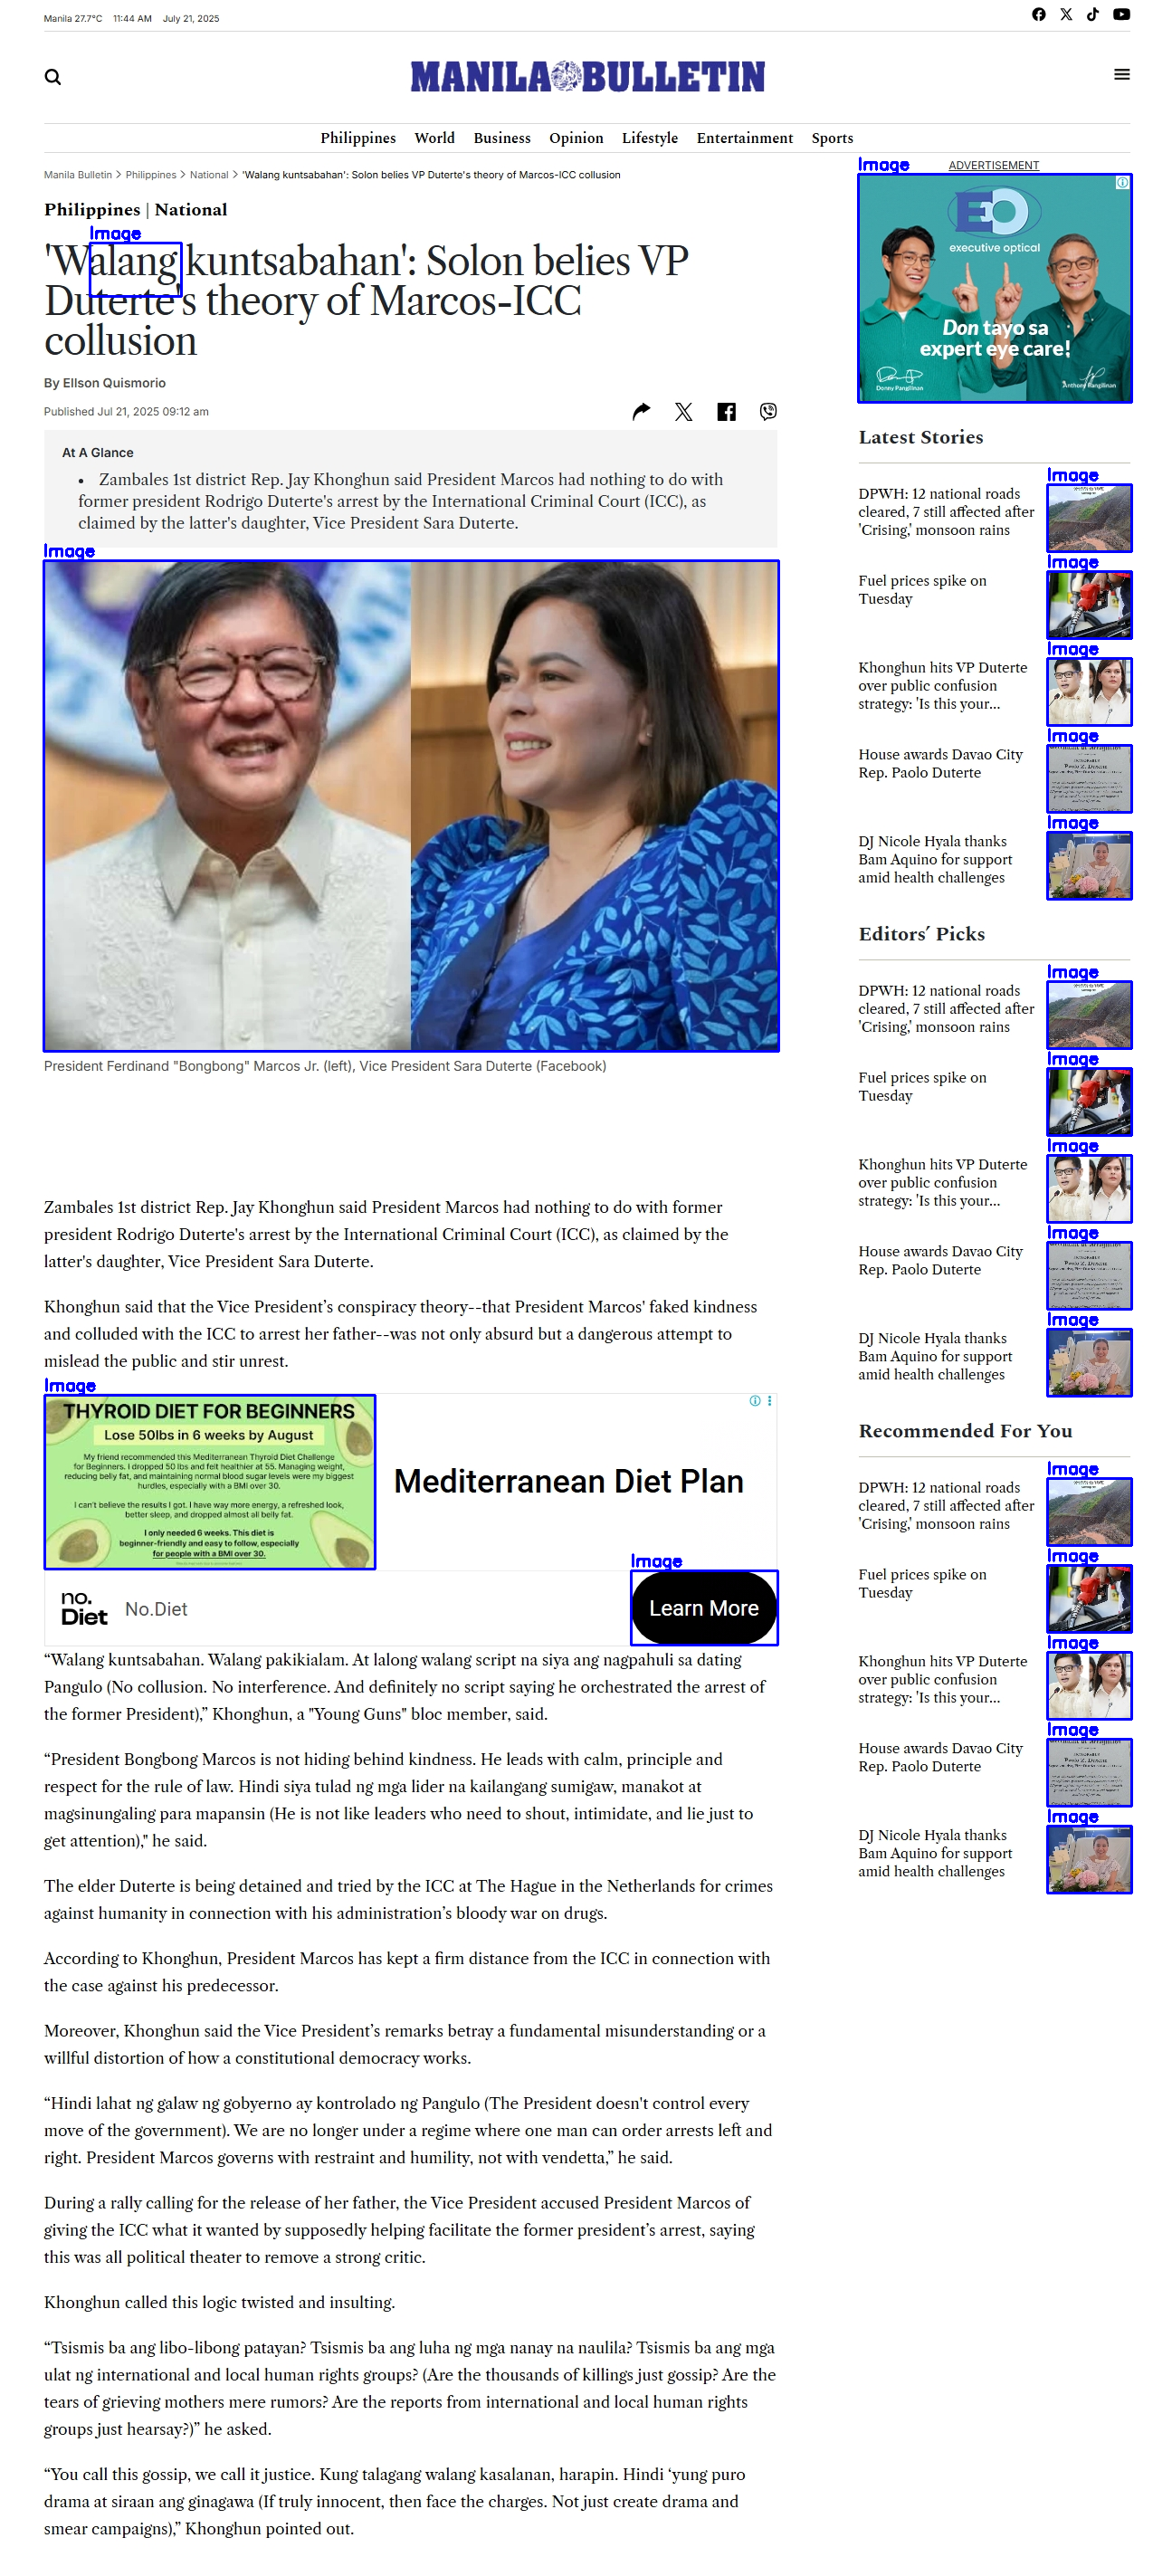

🖼 Combined annotation saved: final_annotated.png


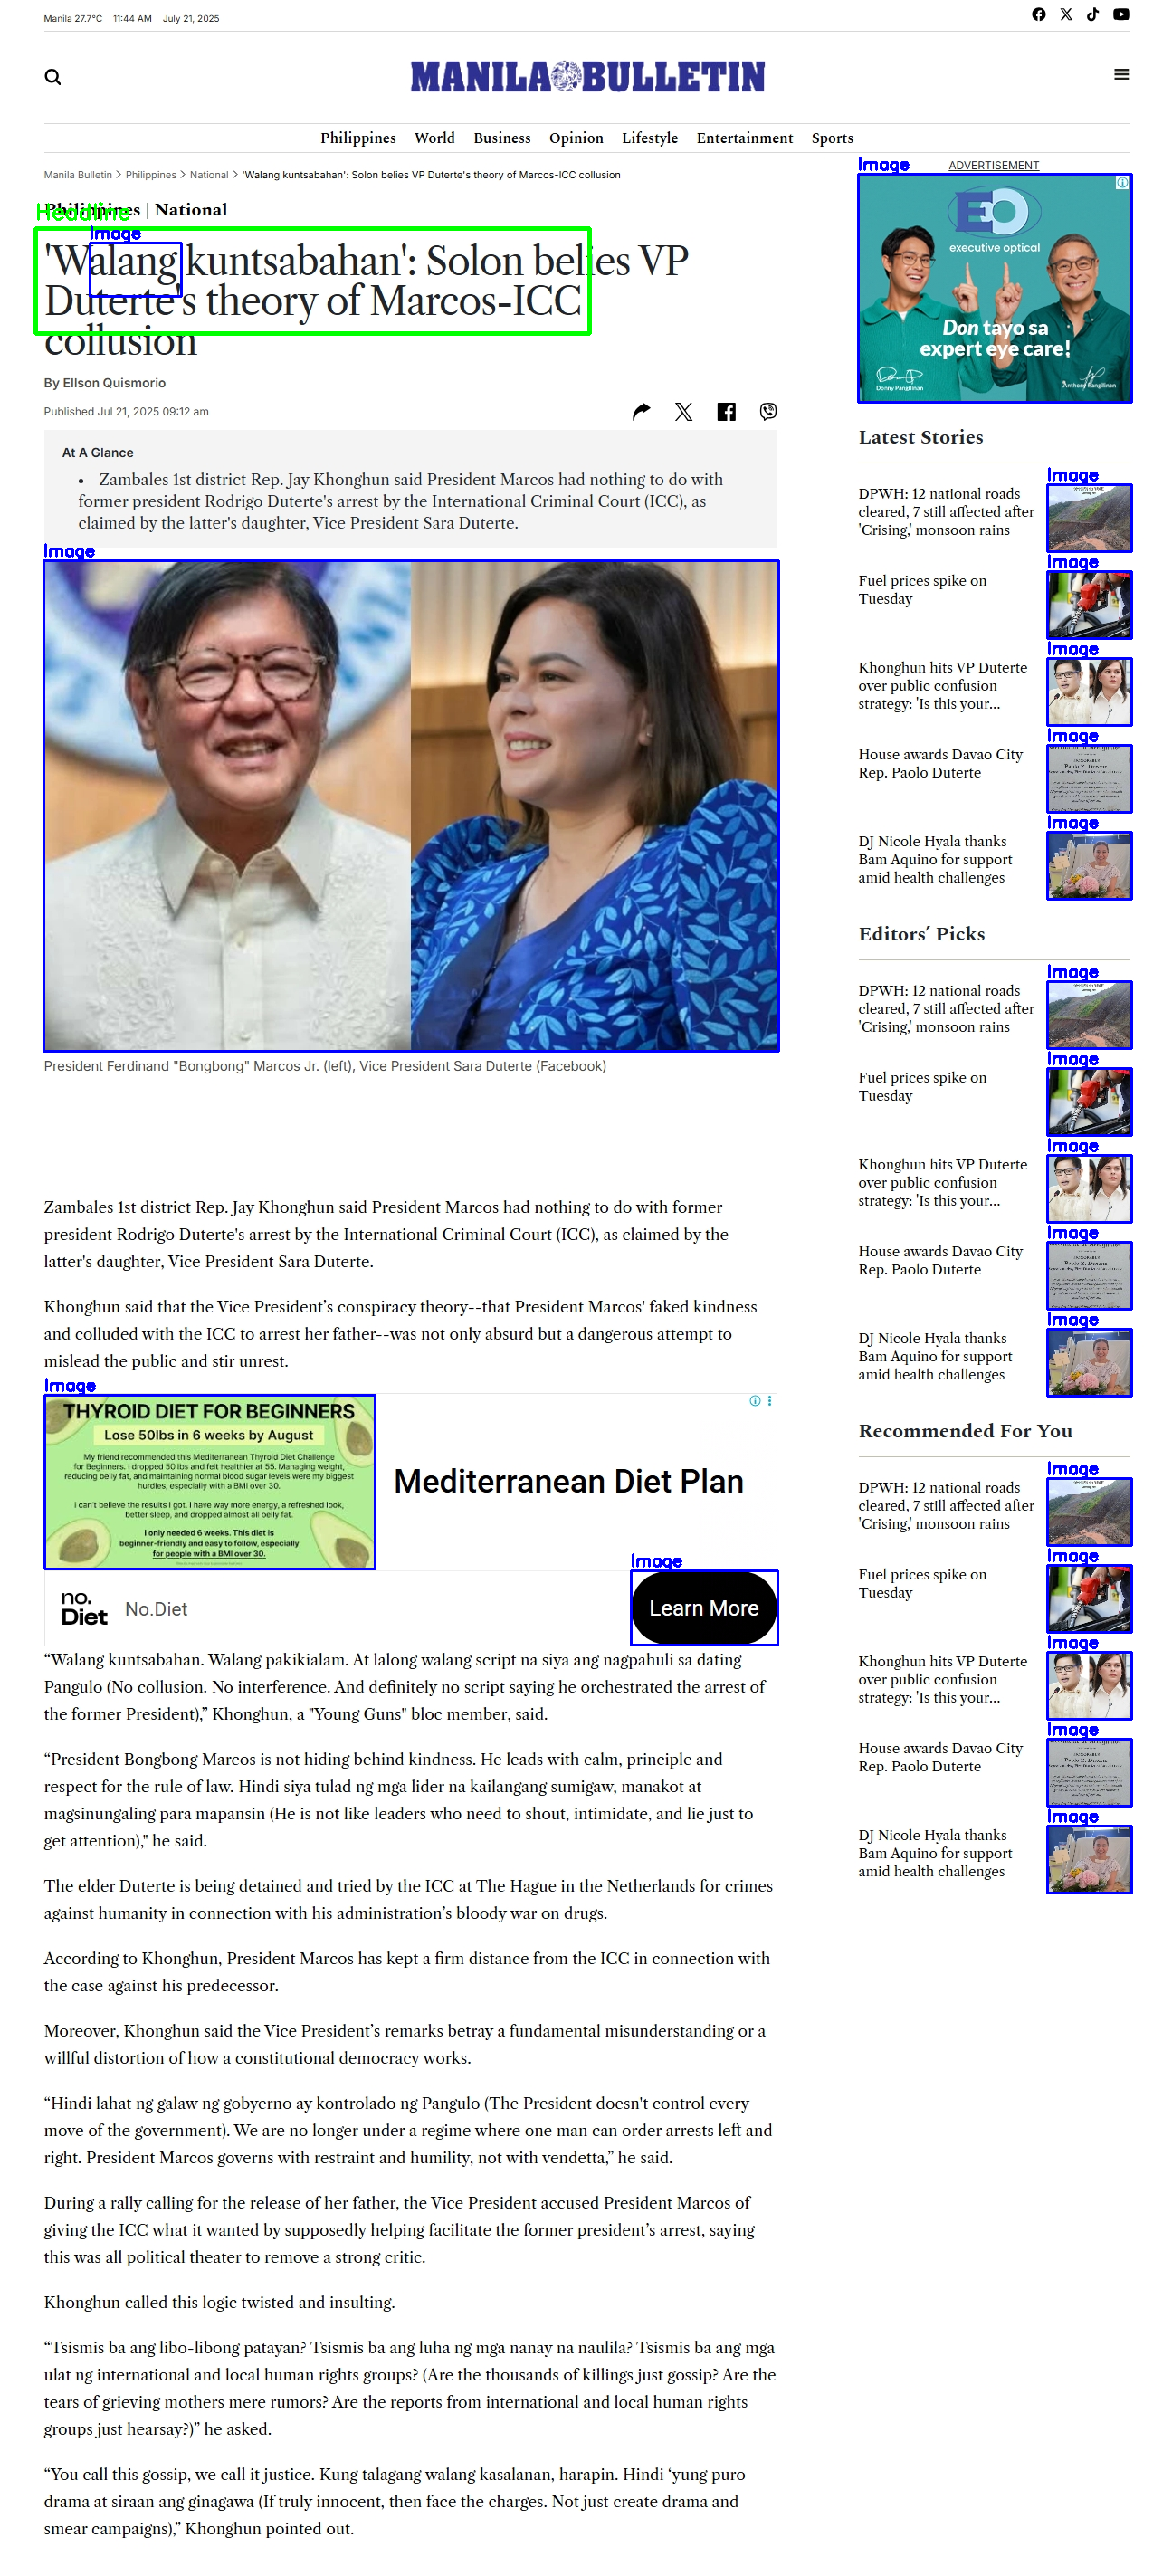

In [75]:
# Replace with your image path
image_path = "./img/Screenshot_21-7-2025_114433_mb.com.ph.jpeg"

# Run OCR & get headline blocks
ocr_results = perform_ocr(image_path)
ranked_blocks = rank_by_font_size(ocr_results)

# Detect image boxes using edge + contour heuristics
embedded_image_boxes = detect_embedded_images_by_structure(image_path)

# Draw both headline + image boxes
annotate_headline_and_images(
    image_path,
    headline_blocks=ranked_blocks,
    image_boxes=embedded_image_boxes,
    output_path="final_annotated.png"
)
